# Content Adressing expriment

In this simple experiment we ask network to use NTM style adressing to retrieve an element from memory based on content similarity. 

The experiment goes as follows. We create a random memory matrix and we extract a random row. This row is then fed as input to the Read head. We expect to get the same row back. Since theres no direct way to use input input output other than approprately adressing the memory matrix, upon successful experiment we can conclude that system learnt content adressing

In [1]:
%load_ext autoreload
%autoreload 2
import random
import unittest
import numpy as np

from dali.utils import Solver, RunningAverage, Capture
import dali.core as D
from memory_access import NTMReadHead
import matplotlib.pyplot as plt
from utils import list_vector_to_mat
%matplotlib inline

In [2]:
memory_size = 20
memory_locations = 128
model = NTMReadHead(input_sizes=[memory_size,],
                    memory_locations=memory_locations,
                    memory_size=memory_size)
initial_locations = D.Mat.zeros((1, memory_locations), constant=True)
solver = Solver(model.parameters(), "rmsprop", learning_rate=0.01)

def generate_example():
    memory = D.random.uniform(-1.0, 1.0,
        size=(memory_locations, memory_size))
    memory.constant = True

    with D.NoBackprop():
        rnd_location = random.randint(0, memory_locations - 1)
        row = memory[rnd_location]
        row.constant = True

    return memory, row, rnd_location

EPOCHS = 2000
MINIBATCH = 10

error_estimate = RunningAverage(0.99)
lowest_error = float('inf')
best_params = None


for epoch in range(EPOCHS):
    for _ in range(MINIBATCH):
        memory, row, row_idx = generate_example()

        retrieved, _    = model.read(row, memory, initial_locations)
        error = (row - retrieved) ** 2
        error.grad()
        D.Graph.backward()
        error_estimate.update(error.w[0,0])
    if lowest_error > float(error_estimate):
        lowest_error = float(error_estimate)
        best_params = [p.get_value(copy=True) for p in model.parameters()]
    if epoch % 100 == 0:
        print("Epoch ", epoch, " error = ", float(error_estimate), flush=True)
    solver.step()

for param, best_param in zip(model.parameters(), best_params):
    param.w = best_param

Epoch  0  error =  0.7703886686735908
Epoch  100  error =  0.17403366702185838
Epoch  200  error =  0.09053551079981778
Epoch  300  error =  0.002879948558072801
Epoch  400  error =  0.0038243738202187474
Epoch  500  error =  0.0003852937550934231
Epoch  600  error =  0.0003950990727282869
Epoch  700  error =  0.0004900828405766264
Epoch  800  error =  0.0003128382515095237
Epoch  900  error =  0.00022343948436882565
Epoch  1000  error =  0.0005335378872608545
Epoch  1100  error =  0.00010681826413269919
Epoch  1200  error =  4.525694441341103e-05
Epoch  1300  error =  0.0002472800260322238
Epoch  1400  error =  0.005309426964273925
Epoch  1500  error =  0.0002884277929396478
Epoch  1600  error =  0.0017582554944455874
Epoch  1700  error =  7.789122250728414e-05
Epoch  1800  error =  0.0005043196040432201
Epoch  1900  error =  0.007683161070091039


## Accuracy

In [6]:
EVAL_EXAMPLES = 100
num_correct = 0
with D.NoBackprop():
    for _ in range(EVAL_EXAMPLES):
        memory, row, row_idx = generate_example()

        retrieved, _    = model.read(row, memory, initial_locations)
        num_correct += sum(abs(row - retrieved).w[0] < 0.01)

print("Accuracy on %d examples is %.0f %%" % (EVAL_EXAMPLES, 100.0 * num_correct / (EVAL_EXAMPLES * memory_size)))

Accuracy on 100 examples is 96 %


input row:      [ 0.61699092  0.0378983  -0.76983124 -0.88780743  0.38928986  0.50725865
 -0.29977119 -0.8259753   0.95960987  0.32745099 -0.83233213 -0.80361426
 -0.41905802 -0.59406215 -0.90811384 -0.75839269 -0.37288111 -0.99024206
 -0.64530694  0.85774696]
retrieved row:  [ 0.61151522  0.03259407 -0.76362687 -0.87870085  0.38064474  0.50394899
 -0.29736051 -0.81753761  0.94945204  0.31709498 -0.82505023 -0.79162246
 -0.41830152 -0.58712143 -0.9011004  -0.74411815 -0.37376559 -0.9697181
 -0.64455473  0.85334671]
Row idx:    121


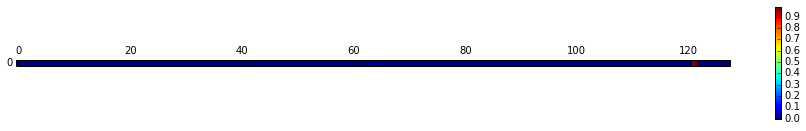

In [14]:
c = Capture()
with D.NoBackprop():
    with c:
        memory, row, row_idx = generate_example()
        retrieved, _    = model.read(row, memory, initial_locations)
        
print("input row:     ", row.w.ravel())
print("retrieved row: ", retrieved.w.ravel())

print("Row idx:   ", row_idx)
plt.matshow(list_vector_to_mat(c.state["read_head_weights"]))
plt.colorbar()

# Content Key

Network seems to learn to pass through input as content key

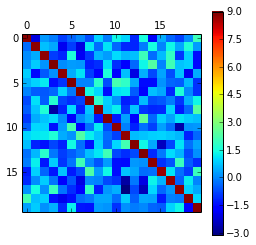

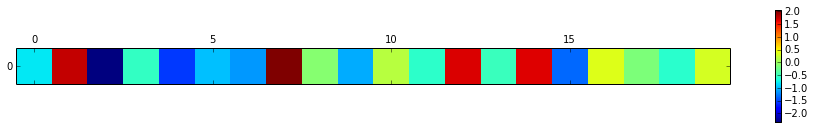

In [5]:
def show_module(m):
    plt.matshow(m.matrices[0])
    plt.colorbar()
    plt.matshow(m.b)
    plt.colorbar()

def print_module(m):
    print(m.matrices[0].w)
    print(m.b.w)
    
show_module(model.addressing.content_key)

In [6]:
print_module(model.addressing.content_key_strength)

[[-0.04908761]
 [ 0.04967965]
 [-0.09675545]
 [ 0.24371789]
 [ 1.20791388]
 [ 0.15788864]
 [-0.4106774 ]
 [-0.79994833]
 [ 0.52855647]
 [-0.6218375 ]
 [-0.20155028]
 [ 0.67973191]
 [ 0.15843973]
 [ 0.61616689]
 [ 0.16520797]
 [ 0.78504503]
 [-1.18746245]
 [-1.67397356]
 [-0.7096439 ]
 [ 1.63275087]]
[[ 9.4568758]]


## Shift

Network learns **not** to shift the input

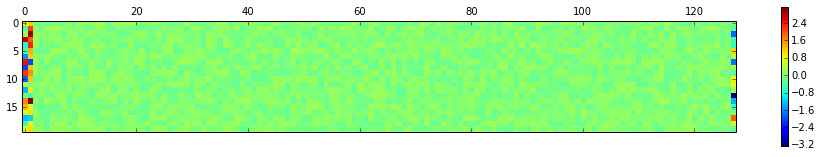

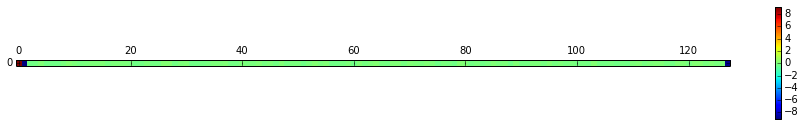

In [7]:
show_module(model.addressing.shift)

In [8]:
print_module(model.addressing.interpolation)

[[-2.41238594]
 [-2.23660803]
 [-1.97500622]
 [ 1.3489933 ]
 [ 2.02993989]
 [-0.07465048]
 [-0.84943843]
 [-1.44223189]
 [-0.85852277]
 [-1.73582745]
 [-0.65865988]
 [ 0.26710719]
 [-0.41750887]
 [-2.94882274]
 [ 1.74704027]
 [-1.13310027]
 [-2.36792827]
 [-1.8008914 ]
 [-0.98661745]
 [ 0.18022487]]
[[ 9.25370121]]


In [9]:
print_module(model.addressing.focus)

[[-0.37626803]
 [ 0.03584782]
 [ 0.3949703 ]
 [ 0.34772545]
 [-0.94564408]
 [-0.25469318]
 [ 0.65711874]
 [ 0.12619394]
 [-0.60617715]
 [-0.09172975]
 [-0.07544992]
 [ 0.19526006]
 [-0.50094563]
 [-0.71175176]
 [ 0.37269717]
 [-0.58599353]
 [ 1.17458439]
 [ 1.54676318]
 [ 0.71668035]
 [-1.19889033]]
[[ 0.98553836]]
